In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import sys


import itertools
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import ndimage

import matplotlib.pyplot as plt

import networkx as nx


from src.depth import DepthPoset, ShallowPair
from src import poset_scores

from tqdm import tqdm

# Load Image

/tmp/ipykernel_207485/766850352.py:3: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)


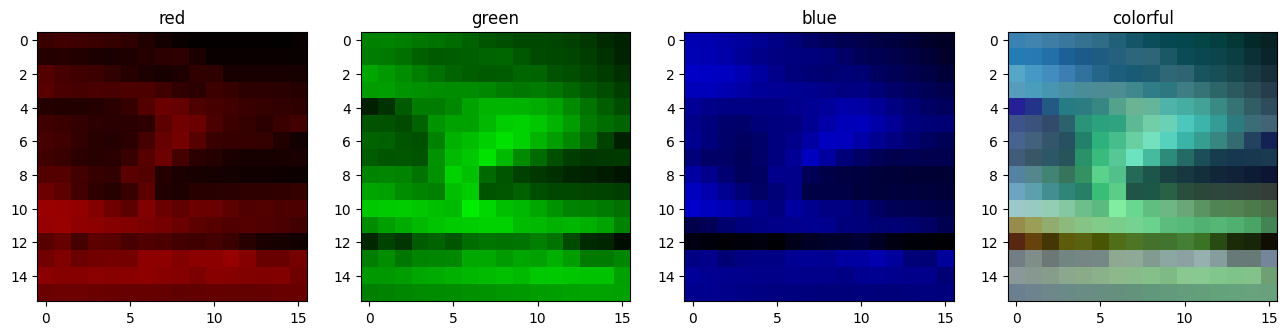

In [3]:
path = 'source/aurora.png'
image = plt.imread(path)[:, :, :3]
image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)



fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for i, color in enumerate(['red', 'green', 'blue']):
    axs[i].set_title(color)
    image_to_show = np.zeros(image.shape)
    image_to_show[:, :, i] = image[:, :, i]
    axs[i].imshow(image_to_show)

#axs[3].set_title('black-white')
#axs[3].imshow(image.mean(axis=2).reshape([image.shape[0], image.shape[1], 1]) * np.ones([1, 1, 3]))

axs[3].set_title('colorful')
axs[3].imshow(image)

plt.show()

# Get border matrix from image

In [4]:
def get_unsorted_order(n, m, with_dims=True):
    """
    """
    # define order
    edges0 = [((x, y), (x+1, y)) for x, y in itertools.product(range(n - 1), range(m))]
    edges1 = [((x, y), (x, y+1)) for x, y in itertools.product(range(n), range(m - 1))]
    squares = list(itertools.product(range(n), range(m)))
    order = squares + edges0 + edges1

    if not with_dims:
        return order

    # define dimensions
    dims = np.concatenate([np.zeros(n*m, dtype=int), np.ones(2*n*m - n - m, dtype=int)])
    assert len(dims) == len(order)

    return order, dims

In [5]:
def get_order_filtrations(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    edges0_filtration = np.concatenate(np.max([img[1:, :], img[:-1, :]], axis=0))
    edges1_filtration = np.concatenate(np.max([img[:, 1:], img[:, :-1]], axis=0))
    squares_filtration = np.concatenate(img)

    filtration = np.concatenate([squares_filtration, edges0_filtration, edges1_filtration, ])
    return filtration

In [6]:
def get_sorted_order(img, with_dims=True, with_filtration=True):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)

    indices = np.lexsort((dims, filtration))
    order = [order[i] for i in indices]
    dims = dims[indices]
    filtration = filtration[indices]
    if with_filtration and with_dims:
        return order, dims, filtration
    if with_dims:
        return order, dims
    if with_filtration:
        return order, filtration
    return order

In [7]:
def diagonal_overlay(n, m):
    rows, cols, data = [], [], []

    for i in range(n):
        # Диагональ слева направо (↘)
        if i < m:
            rows.append(i)
            cols.append(i)
            data.append(True)

        # Диагональ справа налево (↘)
        if i < m:
            rows.append(n - i - 1)
            cols.append(m - i - 1)
            data.append(True)

    return sparse.csr_matrix((data, (rows, cols)), shape=(n, m), dtype=bool)


In [8]:

def transpose_minor_diagonal(bm: sparse.csr_matrix) ->sparse. csr_matrix:
    if bm.shape[0] != bm.shape[1]:
        raise ValueError("Matrix must be square to transpose along the minor diagonal.")
    
    n = bm.shape[0]
    bm_coo = bm.tocoo()
    
    # Меняем местами строки и столбцы, с отражением относительно последнего индекса
    new_row = n - 1 - bm_coo.col
    new_col = n - 1 - bm_coo.row
    
    # Создаём новую матрицу
    return sparse.coo_matrix((bm_coo.data, (new_row, new_col)), shape=(n, n)).tocsr()

In [9]:
def get_unsorted_border_matrix(n, m):
    """
    """
    # edges0
    matrix_e0 = diagonal_overlay(n*m - 1, n*m)
    mask = np.array([i % m != (m - 1) for i in range(matrix_e0.shape[0])])
    matrix_e0 = matrix_e0[mask]

    # edges1
    matrix_e1 = diagonal_overlay(m*(n-1), n*m)
    
    # dimension 1-2 submatrix
    bm = sparse.vstack([matrix_e0, matrix_e1])
    
    # geting full matrix
    N = 3*n*m - n - m
    bm = sparse.vstack([bm, sparse.csr_matrix((N - bm.shape[0], bm.shape[1]))])
    bm = sparse.hstack([sparse.csr_matrix((N, N - bm.shape[1])), bm])

    # transpose over minor diagonal
    bm = transpose_minor_diagonal(bm)
    
    return bm.astype(bool)

In [10]:
def get_sorted_border_matrix(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    n, m = img.shape
    bm = get_unsorted_border_matrix(n, m)

    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)
    indices = np.lexsort((dims, filtration))

    bm = bm[indices, :]
    bm = bm[:, indices]
    
    return bm

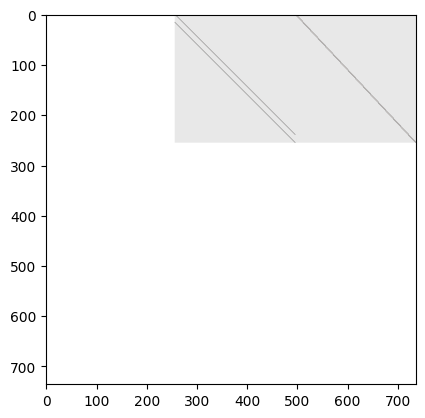

In [11]:
order, dims = get_unsorted_order(image.shape[0], image.shape[1])
bm = get_unsorted_border_matrix(image.shape[0], image.shape[1])

if len(dims) < 4096:
    matrix_dim_condition = dims.reshape((-1, 1)) == dims.reshape((1, -1)) - 1
    plt.imshow(matrix_dim_condition, cmap='Greys', vmin=0, vmax=6)

    bm_to_show = bm.toarray().astype(float)
    bm_to_show[bm_to_show == 0] = np.nan
    plt.imshow(bm_to_show, cmap='Reds')



# Simplifying Class

## Pixels to Disk

Here we are building the map 
$$
    f: D^2\subset \mathbb{R}^2 \to D^2
$$
such that
$$
    f: \delta D^2 \to (\cos\phi, \sin\phi), \phi\in[0, 2\pi)
$$

$n$ ordered points $p_1, ..., p_n \in \delta D^2$:
$$
    f(p_i) = (\cos(i\frac{2\pi}{n}), \sin(i\frac{2\pi}{n}))
$$
and for 1 point $p_c\in D^2/\delta D^2$
$$
    f(p_c) = (0, 0)
$$

We will need this to represent cell as a disk, and calculate height there, based on heights in the $n$ cell vertices

In [12]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def pixel_graph_laplacian(mask):
    """
    Строит дискретный лапласиан по 4-связной решётке на пикселях из mask.
    Возвращает:
    - L: разреженная матрица Лапласиана
    - pixel_to_index: отображение (i,j) -> индекс строки
    - index_to_pixel: обратное отображение
    """
    h, w = mask.shape
    pixel_to_index = {}
    index_to_pixel = {}
    idx = 0
    for i in range(h):
        for j in range(w):
            if mask[i, j]:
                pixel_to_index[(i, j)] = idx
                index_to_pixel[idx] = (i, j)
                idx += 1

    N = len(pixel_to_index)
    L = lil_matrix((N, N))
    for (i, j), k in pixel_to_index.items():
        neighbors = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        deg = 0
        for ni, nj in neighbors:
            if (ni, nj) in pixel_to_index:
                L[k, pixel_to_index[(ni,nj)]] = -1
                deg += 1
        L[k, k] = deg
    return L.tocsr(), pixel_to_index, index_to_pixel

def solve_harmonic(mask, boundary_values):
    """
    Решает уравнение Лапласа внутри маски с граничными условиями.
    boundary_values: dict (i,j) -> значение на границе.
    """
    L, p2i, i2p = pixel_graph_laplacian(mask)
    N = len(p2i)

    b = np.zeros(N)
    fixed = np.zeros(N, dtype=bool)
    x_fixed = np.zeros(N)

    for (i, j), value in boundary_values.items():
        k = p2i[(i,j)]
        fixed[k] = True
        x_fixed[k] = value

    free = ~fixed
    L_free = L[free][:, free]
    b_free = -L[free][:, fixed] @ x_fixed[fixed]

    x = np.zeros(N)
    x[fixed] = x_fixed[fixed]
    x[free] = spsolve(L_free, b_free)

    result = {}
    for k in range(N):
        result[i2p[k]] = x[k]
    return result

def compute_parametrization(mask, boundary_phi, center_pixel):
    """
    mask: 2D np.array of 0/1
    boundary_phi: dict {(i,j): phi in radians}
    center_pixel: (i,j)
    Returns: dict (i,j) -> (r, phi)
    """
    h, w = mask.shape

    # Solve r: 0 in center, 1 on boundary
    boundary_r = {p: 1.0 for p in boundary_phi}
    boundary_r[center_pixel] = 0.0
    r_map = solve_harmonic(mask, boundary_r)

    # Solve phi: fixed on boundary, harmonic inside
    phi_map = solve_harmonic(mask, boundary_phi)

    return {p: (r_map[p], phi_map[p]) for p in r_map}

In [95]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

def extract_ordered_boundary(mask):
    """
    Извлекает упорядоченную границу (в виде списка (i,j)) из бинарной маски.
    Возвращает:
        - список координат (float) вдоль границы, замкнутую ломаную
        - можно интерполировать в целочисленные координаты, если нужно
    """
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("Граница не найдена")
    
    # Если несколько контуров, берём самый длинный
    contour = max(contours, key=len)

    # Переводим из (y, x) в (i, j) и округляем при необходимости
    ordered_boundary = [(int(round(y)), int(round(x))) for y, x in contour]
    ordered_boundary = [(y, x) for y, x in contour]
    ordered_boundary = []
    for y, x, in contour:
        if y%1 == 0:
            y, x = int(y), int(x)
            if not mask[y, x]:
                x += 1
        else:
            y, x = int(y), int(x)
            if not mask[y, x]:
                y += 1
        if (y, x) not in ordered_boundary:
            ordered_boundary.append((y, x))
    

    return ordered_boundary


<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_207485/44713287.py:47: SyntaxWarning: invalid escape sequence '\p'
  axs[0].scatter(boundary_x, boundary_y, color=plt.get_cmap('hsv')(boundary_angles/(2*np.pi)), marker='o', label='Boundary $\phi$', zorder=2)


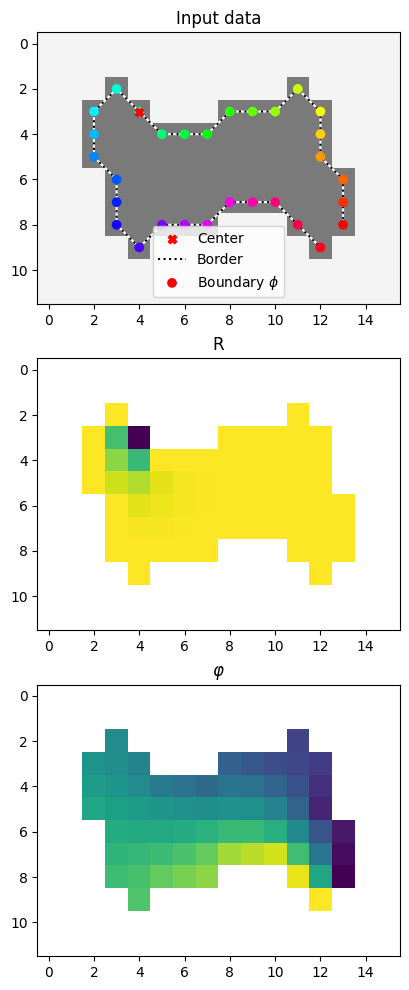

In [142]:
# define mask
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1

# define center
center_x, center_y = 4, 7
center_x, center_y = np.argwhere(mask)[np.random.choice(np.arange(mask.sum(), dtype=int))]

# get the boundary
boundary = extract_ordered_boundary(mask)
boundary_x, boundary_y = np.transpose(boundary) 
boundary_angles = np.linspace(0, 2*np.pi, len(boundary))


# compute parametrization
boundary_phi = {pos: phi for pos, phi in zip(boundary, boundary_angles)}
center_pixel = center_x, center_y

parametrization = compute_parametrization(mask, boundary_phi, center_pixel)

# plot
img_radius = np.nan*mask
img_phi = np.nan*mask

for (x, y), (r, phi) in parametrization.items():
    img_radius[x, y] = r
    img_phi[x, y] = phi
    
    
fig, axs = plt.subplots(3, figsize=(6, 12))
#
axs[0].set_title('Input data')
axs[0].imshow(mask.transpose(), cmap='Greys', vmin=-0.2, vmax=1.8, zorder=0)

axs[0].scatter(center_x, center_y, color='red', marker='X', label='Center', zorder=3)

axs[0].plot(boundary_x, boundary_y, color='white', linestyle='-')
axs[0].plot(boundary_x, boundary_y, color='black', linestyle=':', label='Border')
axs[0].scatter(boundary_x, boundary_y, color=plt.get_cmap('hsv')(boundary_angles/(2*np.pi)), marker='o', label='Boundary $\phi$', zorder=2)
axs[0].legend()

# 
axs[1].set_title('R')
axs[1].imshow(img_radius.transpose())

axs[2].set_title(r'$\varphi$')
axs[2].imshow(img_phi.transpose())

plt.show()



## Simplification itself

In [ ]:
class SimplifiedByCancelations:
    def __init__(self, image, cancelations: list[ShallowPair]=[]):
        """
        The topologica simplification of a 2-dimensional black-white image by canceling shallow pairs.
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        self.shape = self.image.shape
        
        # Geting list of components
        g = nx.Graph()
        g.add_nodes_from(itertools.product(range(image.shape[0]), range(image.shape[1])))
        g.add_edges_from([node.source[1] for node in cancelations])
        self.components = [list(component) for component in nx.connected_components(g)]
        
        # geting the only not canceled pixels in the components
        canceled_pixels = {node.source[0] for node in cancelations}
        self.merge_targets = [set(component) - canceled_pixels for component in self.components]
        assert np.all([len(target) == 1 for target in self.merge_targets])
        self.merge_targets = [next(iter(target)) for target in self.merge_targets]

    def __len__(self):
        """
        Returns the number of components
        """
        return len(self.components)

    def get_segmentation(self, add_frame=False):
        """
        Returns the segmentation based on the cancelations

        Parameters:
        -----------
        add_frame: bool
            Add a frame as an aditional component index len(self)

        Returns:
        --------
        new_image: 2-dimensional integer np.array
        """
        if add_frame:
            segement_matrix = np.zeros([self.shape[0] + 1, self.shape[1] + 1])*len(self)
            segement_matrix[1:-1][1:-1] = self.get_segmentation(add_frame=False)
            return segement_matrix

        segement_matrix = np.zeros(self.shape)*np.nan
        for i, component in enumerate(self.components):
            rows, cols = zip(*component)
            segement_matrix[rows, cols] = i
        return segement_matrix
    
    def get_flat_representation(self):
        """
        Returns the simplified image, assuming for every component the representative merge target pixel value

        Returns:
        --------
        new_image: 2-dimensional np.array
        """
        new_image = self.image.copy()
        for component, (merge_target_x, merge_target_y) in zip(self.components, self.merge_targets):
            value = self.image[merge_target_x, merge_target_y]
            rows, cols = zip(*component)
            new_image[rows, cols] = value
        return new_image

    def get_component_connectivity_graph(self, add_frame=False):
        """
        Returns the graph, where 
        nodes are component indices
        edges exists if 2 components have a border (4-connectivity)

        Parameters:
        -----------
        add_frame: bool
            Add an aditional component index len(self), representing the frame of the image

        Returns:
        --------
        g: nx.Graph
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)
        
        edges_v = np.transpose([segment_matrix[1:, :], segment_matrix[:-1, :]], (1, 2, 0))[segment_matrix[1:, :] != segment_matrix[:-1, :]]
        edges_h = np.transpose([segment_matrix[:, 1:], segment_matrix[:, :-1]], (1, 2, 0))[segment_matrix[:, 1:] != segment_matrix[:, :-1]]
        edges = np.concatenate([edges_v, edges_h])
        edges = np.unique(np.sort(edges, axis=1), axis=0)

        g = nx.graph()
        g.add_nodes_from(np.unique(segment_matrix))
        g.add_edges_from(edges)
        return g
    
    def get_vertices(self, add_frame=False):
        """
        Returns indices of pixel, in which neighbourhood more than 2 segments.

        The neighbourhood of a pixel contains 4 pixel: this pixel itself 

        Parameters:
        -----------
        add_frame: bool
            Do we count frame as a segment
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)

        slices = np.array([segment_matrix[1:, 1:], 
                           segment_matrix[1:, :-1], 
                           segment_matrix[:-1, 1:], segment_matrix[:-1, :-1]])
        nsegments = np.apply_along_axis(lambda row: len(np.unique(row)), axis=0, arr=slices)
        vertices = np.argwhere(nsegments >= 3)
        rows, cols = zip(*vertices)
        vertex_segments = slices[:, rows, cols]
        vertex_segments = [tuple(np.unique(vertex_segment)) for vertex_segment in vertex_segments.transpose()]

        if add_frame:
            vertices -= 1
    
    def classify_components(self) -> list[str]:
        """
        Defines the types for each component. 
        There are 3 types are possible:
        - 'min' - local minima
        - 'max' - local maxima
        - 'saddle' - saddle
        """            
        try:
            self.component_types
        except NameError:
            connectivity_graph = self.get_component_connectivity_graph(add_frame=False)
            component_types = []
            for i, (i_merge_target_x, i_merge_target_y) in enumerate(self.merge_targets):
                i_value = self.image[i_merge_target_x, i_merge_target_y]
                neighbors = list(connectivity_graph.neighbors(i))
                neighbors_merge_target_x, neighbors_merge_target_y = zip(np.array(self.merge_targets)[neighbors])
                neighbors_values = self.image[neighbors_merge_target_x, neighbors_merge_target_y]
                if i_value <= neighbors_values:
                    i_type = 'min'
                elif i_value >= neighbors_values:
                    i_type = 'max'
                else:
                    i_type = 'saddle'
                component_types.append(i_type)
            self.component_types = np.array(component_types)
        return self.component_types
                


In [113]:
class DepthSimplifyer:
    def __init__(self, image):
        """
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        
        order, dims, filtration = get_sorted_order(self.image)
        bm = get_sorted_border_matrix(self.image)
        self.depth_poset = DepthPoset.from_border_matrix(border_matrix=bm.toarray().astype('int8'), dims=dims, 
                                                         filter_values=filtration, sources=order)

    def get_simplified(self, cancelations: list[ShallowPair]=[]) -> SimplifiedByCancelations:
        """
        """
        cancelations_with_descendats = self.depth_poset.get_ancestors(cancelations, include=True).nodes
        return SimplifiedByCancelations(self.image, cancelations_with_descendats)
    
    def get_simplified_by_condition(self, condition=lambda cell: False) -> SimplifiedByCancelations:
        """
        """
        cancelations = self.depth_poset.subposet(node_condition=condition).nodes
        return self.get_simplified(cancelations)

    def get_simplified_by_fixing_height(self, height: int) -> SimplifiedByCancelations:
        """
        """
        pass

    def get_simplified_by_canceling_minimals(self, n_iters: int=1) -> SimplifiedByCancelations:
        """
        """
        dp = self.depth_poset
        minimal_nodes = []
        for i in range(n_iters):
            minimal_nodes += list(dp.iterate_minimal_nodes())
            dp = dp.subposet(node_condition=lambda node: node not in minimal_nodes)
        return self.get_simplified(cancelations=minimal_nodes)

    def get_simplified_by_canceling_short_lifes(self, life_length: float) -> SimplifiedByCancelations:
        """
        """
        condition = lambda node: node.death_value - node.birth_value < life_length
        return self.get_simplified_by_condition(condition=condition)

# Experiment

## Get Depth Posets from an Image

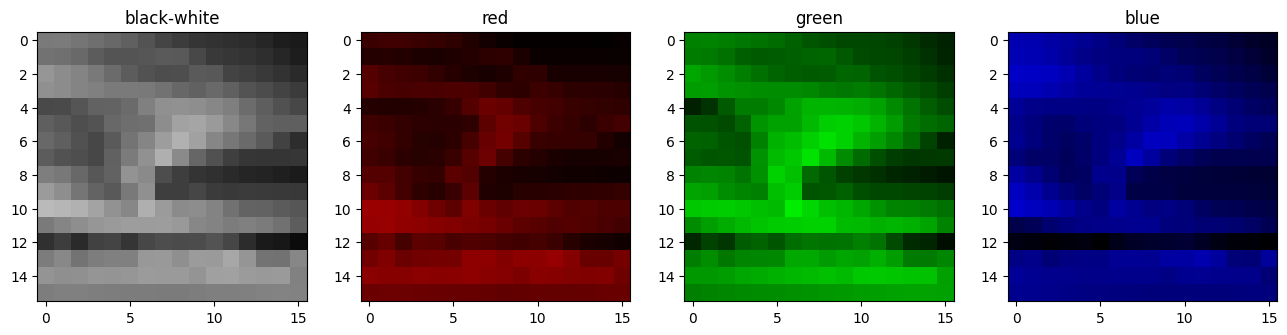

In [114]:
cases = {
    'black-white': image.mean(axis=2),
    'red': image[:, :, 0], 
    'green': image[:, :, 1], 
    'blue': image[:, :, 2], 
}

case_representations = {
    'black-white': lambda img: np.transpose([1*img, 1*img, 1*img], (1, 2, 0)), 
    'red': lambda img: np.transpose([1*img, 0*img, 0*img], (1, 2, 0)), 
    'green': lambda img: np.transpose([0*img, 1*img, 0*img], (1, 2, 0)), 
    'blue': lambda img: np.transpose([0*img, 0*img, 1*img], (1, 2, 0)), 
}

fig, axs = plt.subplots(1, len(cases), figsize=(4*len(cases), 4.5))

for i, key in enumerate(cases.keys()):
    axs[i].set_title(key)
    img = case_representations[key](cases[key])
    axs[i].imshow(img)




In [115]:
simplifyers = {key: DepthSimplifyer(img) for key, img in tqdm(cases.items(), total=len(cases))}

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


In [116]:
dps = {key: simplifyer.depth_poset for key, simplifyer in simplifyers.items()}

scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_relations, 
          poset_scores.number_of_components,
          poset_scores.height, 
          poset_scores.width,
          ]

case_scores = pd.DataFrame({key: {score.__name__: score(dp) for score in scores} for key, dp in dps.items()})
case_scores

,black-white,red,green,blue
number_of_nodes,255,255,255,255
number_of_relations,136,115,144,113
number_of_components,121,143,114,142
height,3,3,4,3
width,238,233,238,243


## Iteratively Canceling Minimal Nodes

In [117]:
max_height = case_scores.loc['height'].max()

max_height

np.int64(4)

In [118]:
df_simplifications = pd.DataFrame([{key: simplifyer.get_simplified_by_canceling_minimals(n_iters=i) for key, simplifyer in simplifyers.items()} for i in range(max_height)])

df_simplifications

,black-white,red,green,blue
0,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
1,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
2,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
3,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...


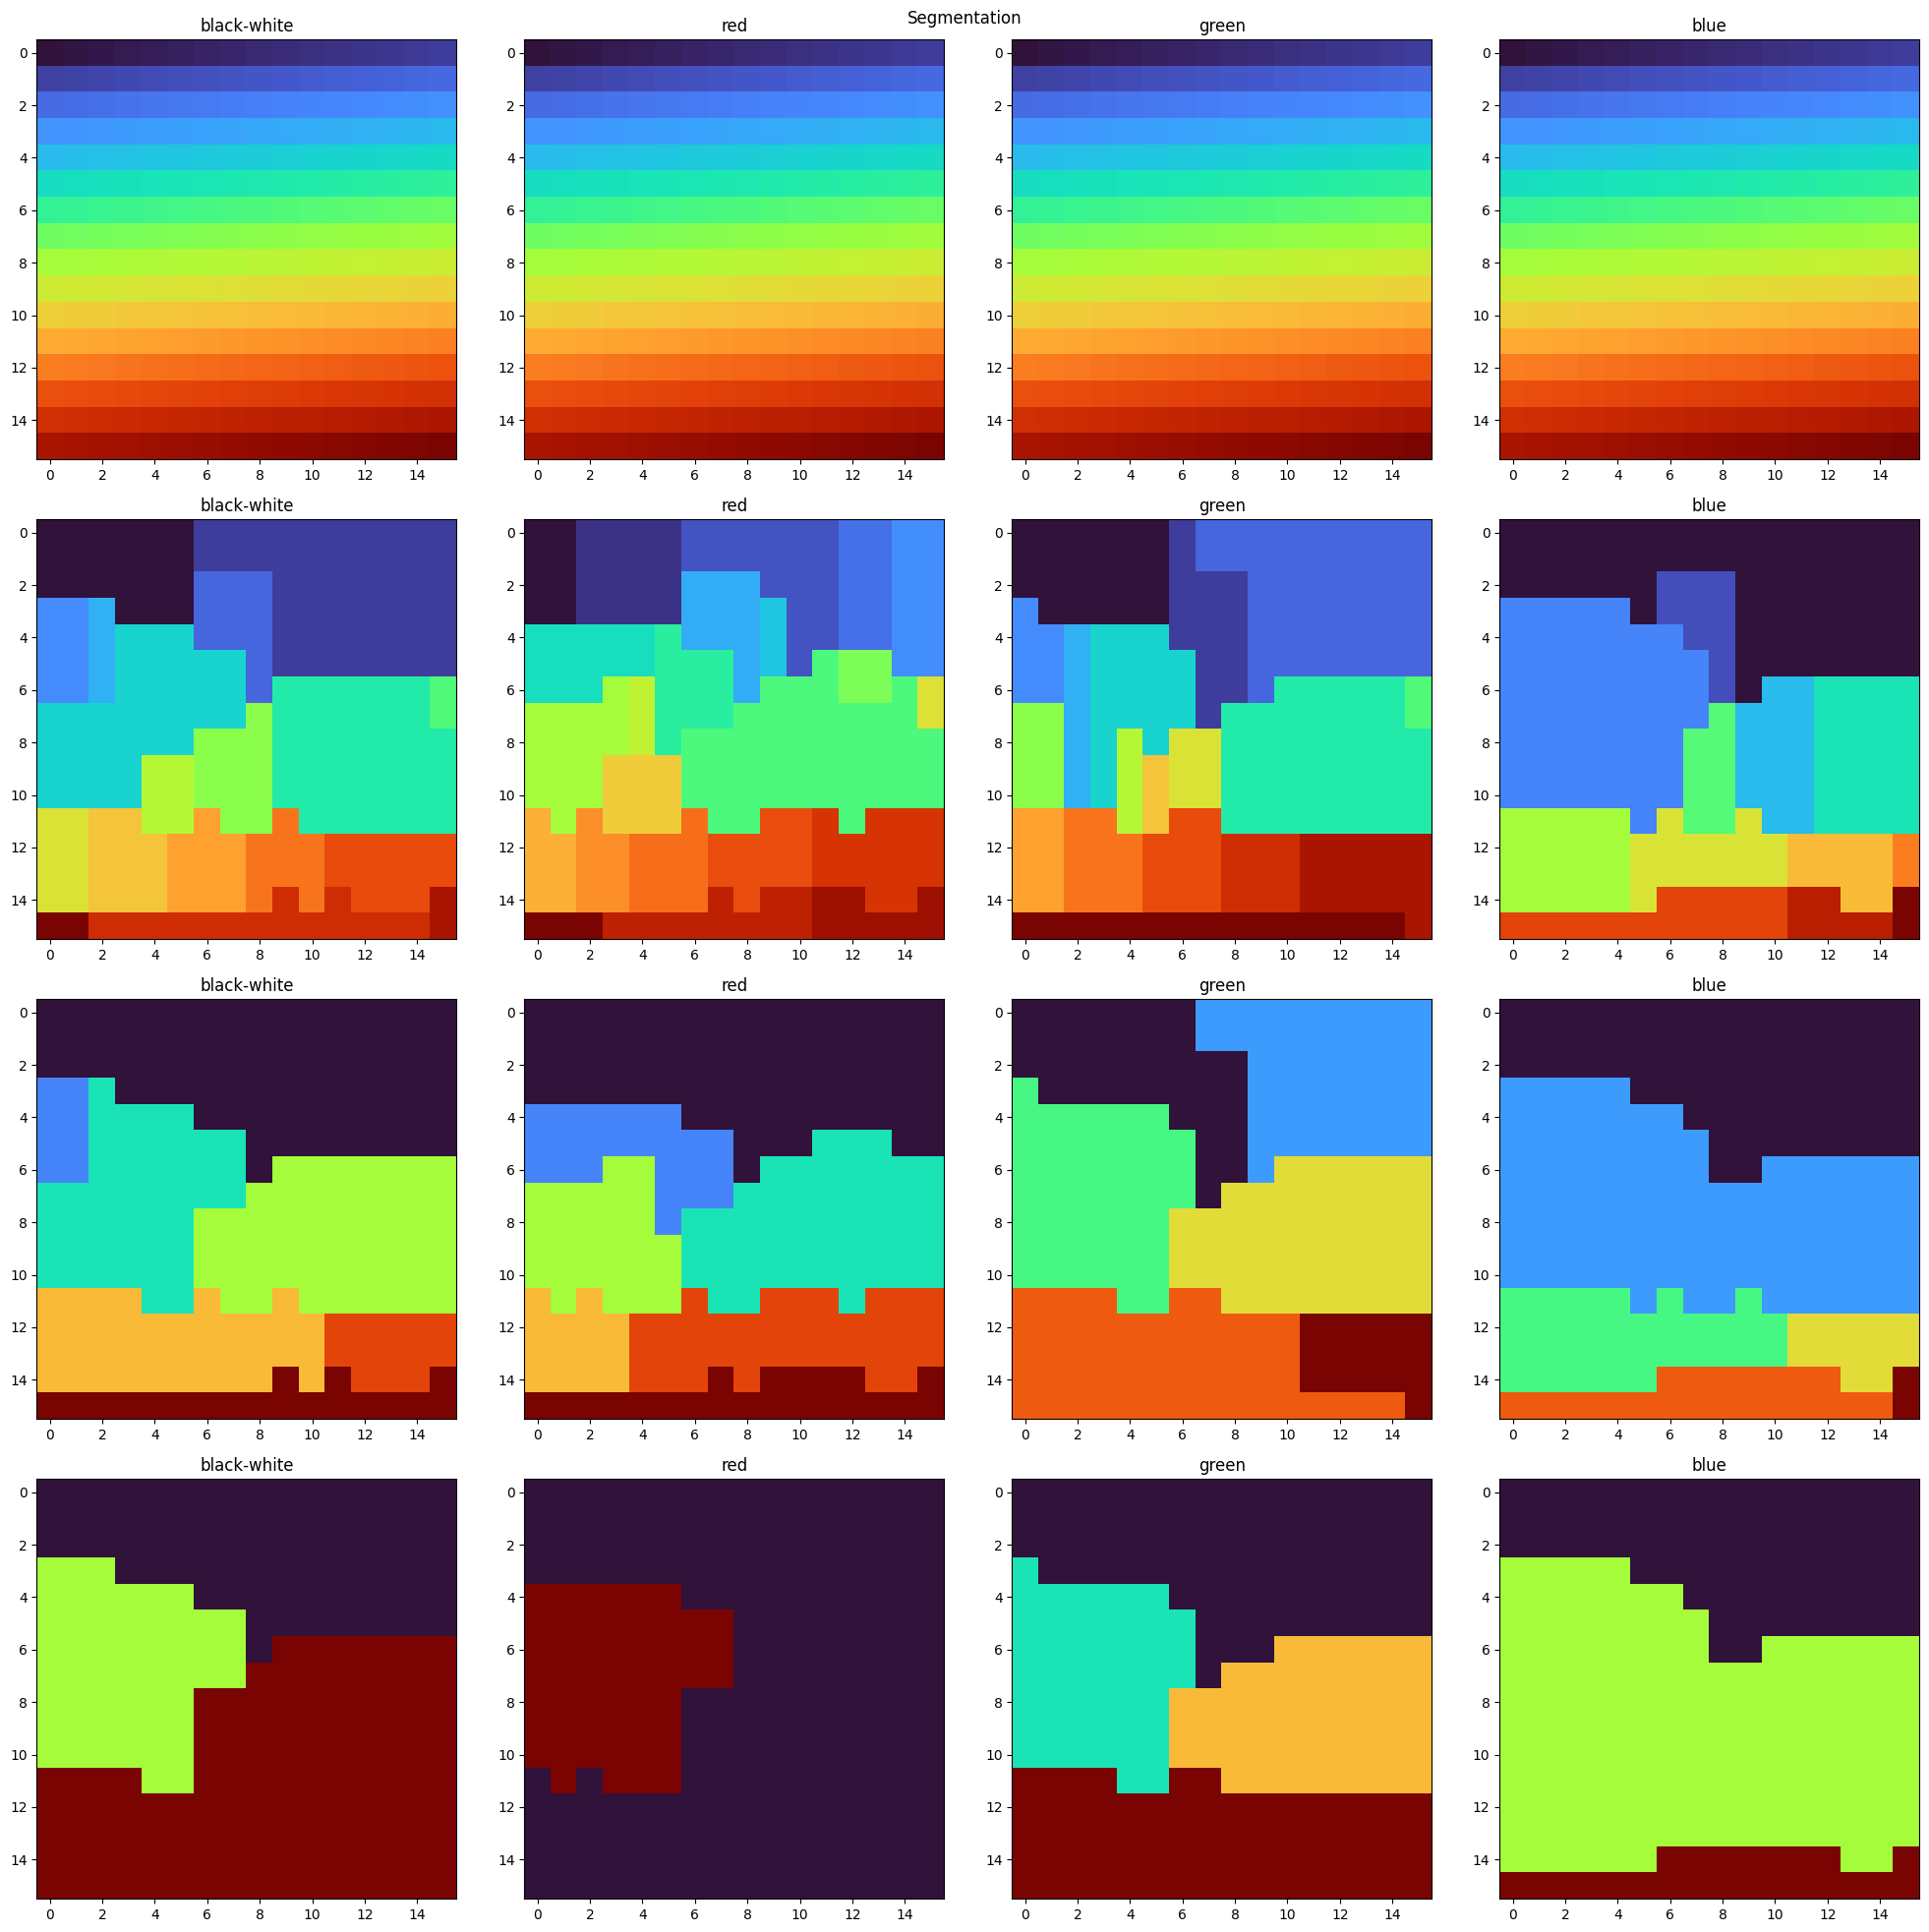

In [ ]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Segmentation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].get_segmentation()
    
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

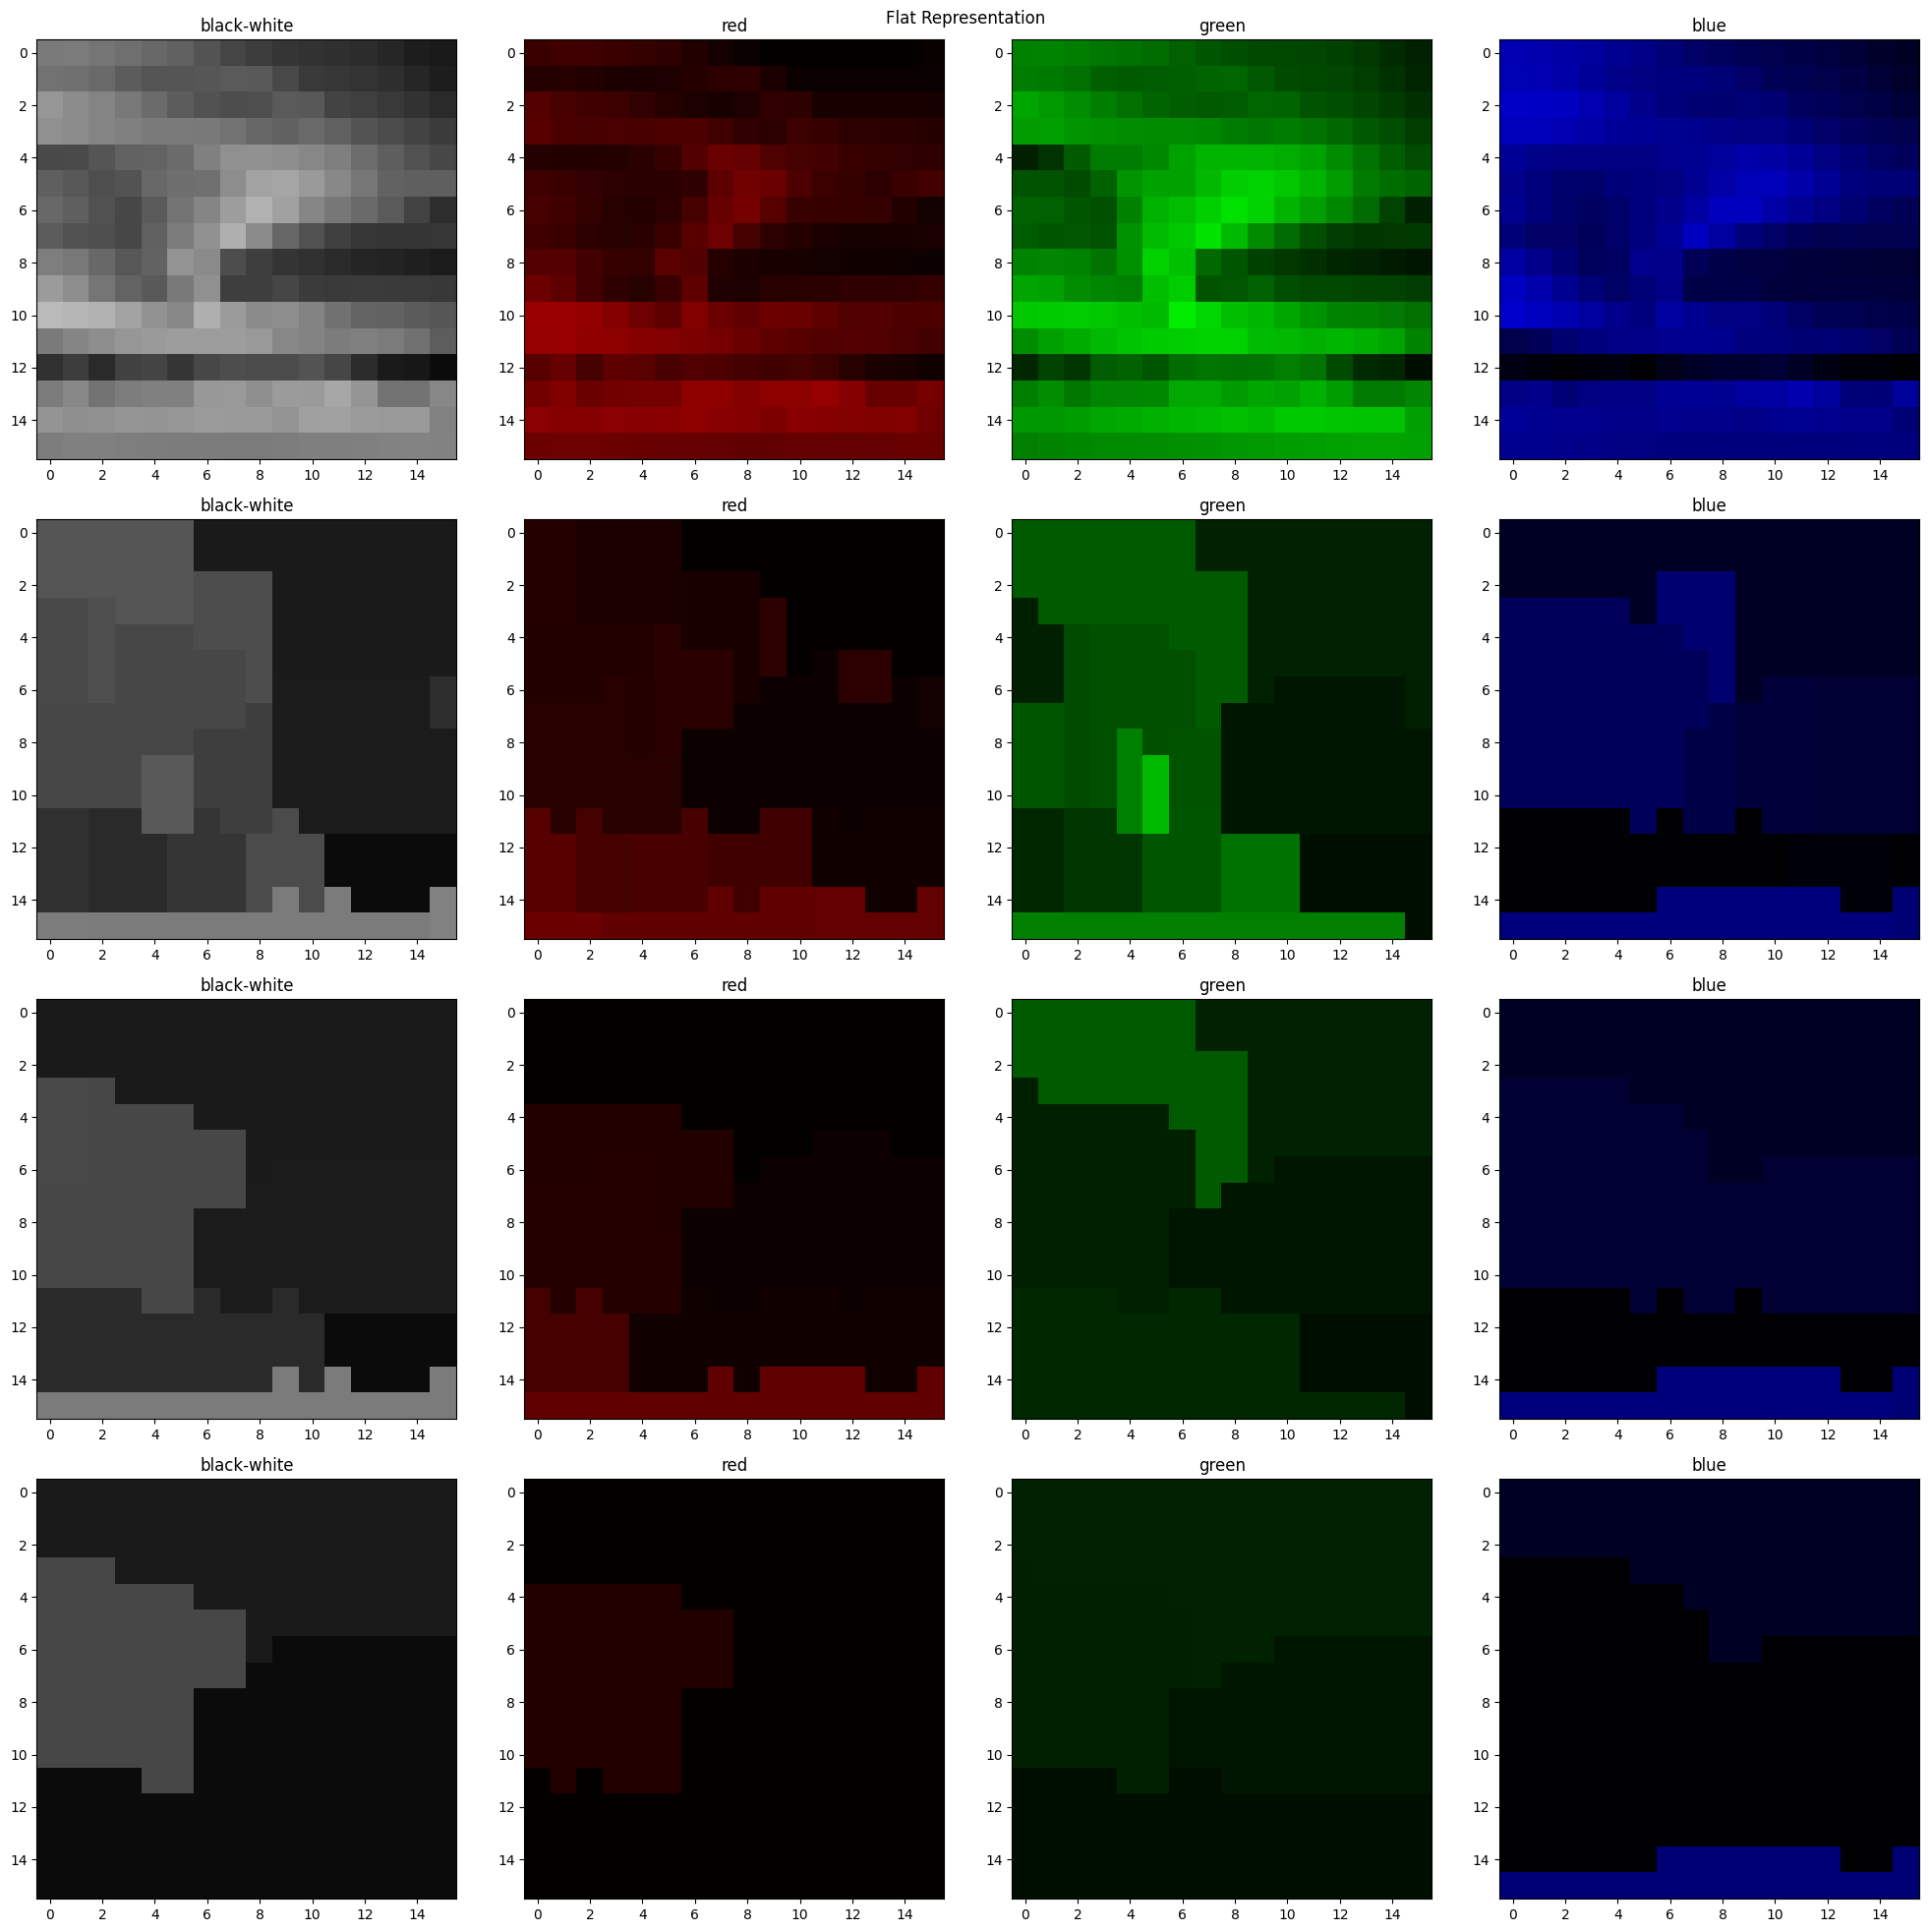

In [124]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Flat Representation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].get_flat_representation()
    img = case_representations[key](img)
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

# Reduction algorithms for sparse border matrices